# Лабораторная работа №1 
# Тема: "Цифровая обработка сигналов". 
Выполнил студент группы № 9381, Кравченко Павел(Вариант 8).

## Цель работы.
Изучить возможности библиотек Python для решения цифровых задач обработки сигналов.

## Задачи.
1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект "Эхо". Получить сигнал после работы аудио-эффекта.
6. **Бонусное задание:** эффект Distortion (классический вариант). Получить сигнал после работы аудио-эффекта.


## Выполнение работы.

### Загрузка аудиосигнала и построение огибающей.

Имеется сигнал $x(i), i = 0,1,...,N-1$. Хотим построить огибающую $y(j), j = 0,1,...,n-1$. Пусть $m = \left[ \frac{N} n \right] $ - число точек в интервале усреднения. Тогда $y(i) = \frac{1} m \displaystyle\sum^{mj+m-1}_{k=mj} |x(k)| $

Считывание и проигрывание аудиофайла:

In [1]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import wave
import math

path = '03-01-05-01-01-01-08_A8.wav'
ipd.Audio(path)

/tmp/ipykernel_57963/1520870184.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  frequency, signal_ = wavfile.read(path) #извлекли частоту дескретизации и данные из файла


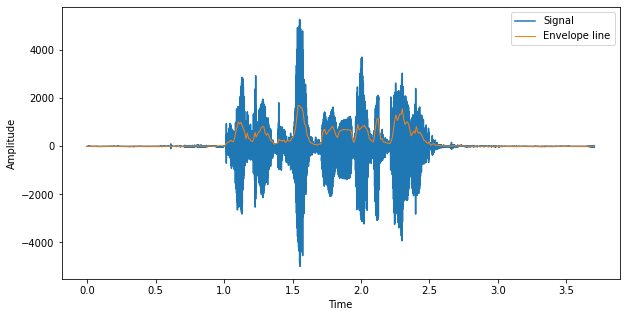

In [2]:
frequency, signal_ = wavfile.read(path) #извлекли частоту дескретизации и данные из файла
n=400
m = math.floor(len(signal_) / n)#число точек в интервале усреднения
len_signal=len(signal_)/frequency
env_line = np.linspace(0, len_signal, n)
env_line_values = [] #значения для графика огибающей

for j in range(n):
  sum = 0
  for k in range(m * j, m * j + m):
    sum += abs(signal_[k])
  env_line_values.append(sum / m)
  
time = np.linspace(0, len_signal, len(signal_))
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(time, signal_, label="Signal")
plt.plot(env_line, env_line_values, label="Envelope line", linewidth=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


### Фильтрация сигнала.

Применим фильтр нижних частот. 

Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$, порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}} {F_{d}}$

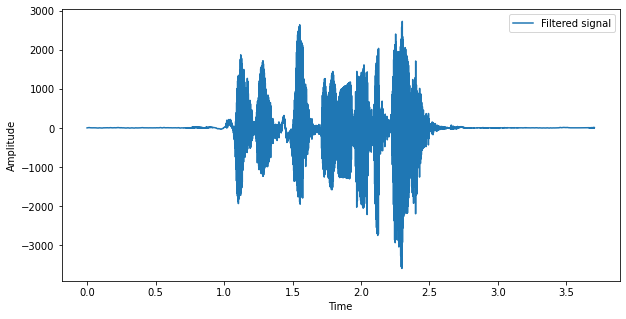

In [3]:
from scipy import signal
F_s = 1000
m = 5 
wn = 2 * (F_s / frequency) 
b, a = signal.butter(m, wn, "lowpass") 
filted_sound = signal.filtfilt(b, a, signal_) #получили сигнал после фильтрации

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(time, filted_sound, label="Filtered signal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

wavfile.write('filtered.wav',frequency, filted_sound.astype(np.int16))
ipd.Audio('filtered.wav')

### Детектор сигнал/шум.

Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$

Определяем порог детектора — $Th = \alpha \cdot mid$, где $0 \lt; \alpha \lt; 1$ подбирается экспериментально. Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

* Событие ”начало сигнала”. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.
* Событие ”окончание сигнала”. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$.

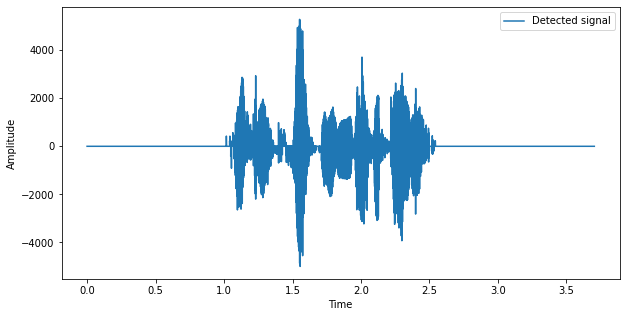

In [4]:
mid = 0
N=len(signal_)
for k in range(N):
  mid += abs(signal_[k])
mid = mid / N
alpha = 0.6
Th = alpha * mid
k=10

keep_sign = 0
lose_sign = 0
y = np.zeros(N)
for i in range(N):
    if abs(signal_[i]) > Th:
        keep_sign += 1
        lose_sign = 0
        if keep_sign >= k:
            y[i] = signal_[i]
    else:
        lose_sign += 1
        keep_sign = 0

        
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(time, y, label="Detected signal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

wavfile.write('detected.wav',frequency, y.astype(np.int16)) 
ipd.Audio('detected.wav')


### Эффект ”Эхо”
Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} \geqslant 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_{1} \gt \alpha_{2} \gt \dots \gt \alpha_{N_{L}}$.
* Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
* Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости $\gamma$.
* Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима
пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее: $D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots,N_L$.
Для готовой конфигурации пользователь вручную задает последовательность $D_1 \gt D_2 \gt \dots \gt D_{N_L}$.

In [6]:
N_L = 9 #Число линий задержки
D = np.zeros(N_L) 
gam = 0.75 #коэффициент применимости
v = 335 #скорость звука
dist = float(input("Расстояние до препятствия - "))/v 
D[0] = dist
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] #Весовые коэффициенты линий задержки

for i in range(1, N_L):
    D[i] = D[0] * (2 ** ((-i)/N_L))

proc_signal = [0]*(int((np.sum(D) + N / frequency + 1) * frequency))
for i in range(N-1):
    n = 0
    for j in range(N_L):
        n+=D[j]   
        proc_signal[i+int(n*frequency)] += signal_[i] * alpha[j]   
   

F_s = 1000
m = 5 
wn = 2 * (F_s / frequency) 
b, a = signal.butter(m, wn, "lowpass") 
echo_sound = signal.filtfilt(b, a, proc_signal)*gam #получили сигнал после фильтрации


for i in range(N):
    echo_sound[i]+=signal_[i]
    
wavfile.write('echo_effect.wav',frequency, echo_sound.astype(np.int16)) 
ipd.Audio('echo_effect.wav')

Предполагаемое расстояние до препятствия - 7



### Эффект ”Distortion”
Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1, \dots, N - 1$. Пользователь задает порог — $Th$ и максимальное значение сигнала $Max \gt Th$.

Тогда $Y(i) = 
 \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| \gt Th
 \end{cases}
$

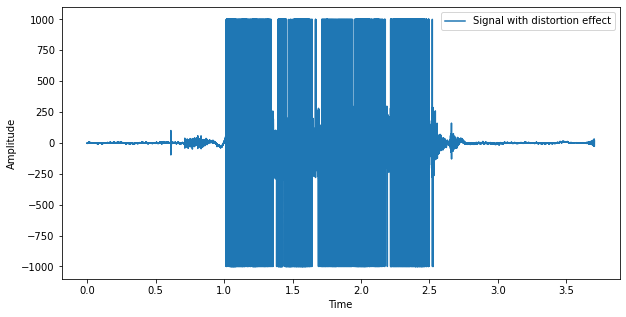

In [7]:
Th = 300
Max = 1000
distort = np.zeros(N)

for i in range(N):
    if (abs(signal_[i]) < Th):
        distort[i] = signal_[i]
    else:
        distort[i] = Max * np.sign(signal_[i])
       
        
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(time, distort, label="Signal with distortion effect")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

wavfile.write('distortion_effect.wav',frequency, distort.astype(np.int16)) 
ipd.Audio('distortion_effect.wav')


### Вывод.

В ходе выполнения лабораторной работы были изучены возможности библиотек python(scipy, IPython.display, wave). С их помощью были реализованы способы цифровой обработки сигналов. Также были изучены принципы работы с Jupyter Notebook. 